# Optical Character Recognition (OCR) on Mathematical Expression

Optical Character Recognition refers to extracting written texts from digital images into machine readable text. OCR can be used on printed, handwritten, and natural scene texts [3]. In this project, our goal is to extracting each single math symbol from mathematical expressions and ouputting the corresponding latex codes. For example, for the expression cos(x)=0, we have the collection of latex codes {\cos, x, (, ), =, 0}.

Our input data are the collection of four datasets: 
* expressmatch: University of Sao Paulo, 
* MathBrush: University of Waterloo, 
* KAIST: KAIST lab, 
* HAMEX: University of Nantes. 

from CROHME version 2013, the 2013 Competition on Recognition of Online Handwritten Mathematical Expressions [2].

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import os
from os import listdir as ls
import numpy as np
import matplotlib
import pickleshare
import sklearn
import skimage
from skimage.draw import line
from skimage.morphology import thin
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import argparse
import cv2
import one_hot
import pickle

# Phase I: Build our Mathematical Expression Recognition Dataset

The original data are in inkml files, we first perform the following steps using python files in terminal [5]: 
* Extract trace groups from inkml files.
* Convert extracted trace groups into images. Images are square shaped bitmaps with only black (value 0) and white (value 1) pixels. Black color denotes patterns (ROI).
* Label those images according to inkml files.
* Flatten images to one-dimensional vectors.
* Convert labels to one-hot format.
* Dump training and testing sets separately into outputs folder.

Since the dataset is imbalanced, we then balance the dataset using python file balance.py on terminal [5].
* command line argument: python balance.py -b 28 -ub 3000

In [30]:
path = '/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/'
data_dir = os.path.join(path, 'CROHME_full_v2/')
ls(data_dir)

['CROHME2013_data',
 'index.html',
 'CROHME_papers',
 'CROHME2012_data',
 'evaluationTools',
 'ParticipantsResults2012',
 'readme.txt',
 'CROHME2011_data',
 '.ipynb_checkpoints']

In [31]:
test_path = path+'outputs/test/'
train_path = path+'outputs/train/'

In [32]:
train_data = pd.read_pickle(train_path+'train.pickle', compression='infer')
test_data = pd.read_pickle(test_path+'test.pickle', compression='infer')

In [8]:
train_ds = pd.DataFrame(train_data)
train_ds

,features,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...
310899,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310900,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310901,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310902,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
test_ds = pd.DataFrame(test_data)
test_ds

,features,label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
5494,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5495,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5496,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5497,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Our Mathematical Expression has 310,904 training data and 5499 testing data. For extracting the image, we use 28x28 input shape so the flattened vector has dimension 784. In total, there are 101 classes including 
* digits: 0 1 2 3 4 5 6 7 8 9
* operators: ( ) [ ] + - =
* lowercase_letters: a b c d e f g h i j k l m n o p q r s t u v w x y z
* uppercase_letters: A B C E F G H I L M N P R S T V X Y
* greek: \Delta \alpha \beta \gamma \lambda \mu \phi \pi \sigma \theta
* miscellaneous: \times = \in \pm ! \rightarrow \sin \cos \tan \lim \log \exists \forall \sqrt / \geq \gt \leq \lt \neq \div
* symbols: \int \infty \sqrt

# Section I: Deep Network Trained on Flattend Images

First, since we've flattened the images, we build a purely dense network and train the model on the flattened images. The result turns out to be better than expectation.

Step 1: To fit in the model, we first tranfer numpy array into tensors. 

In [25]:
train_feature_values = train_ds['features'].values
train_label_values = train_ds['label'].values
test_feature_values = test_ds['features'].values
test_label_values = test_ds['label'].values

In [11]:
train_feature_tensor = tf.convert_to_tensor(train_feature_values.tolist())
train_label_tensor = tf.convert_to_tensor(train_label_values.tolist())

In [12]:
test_feature_tensor = tf.convert_to_tensor(test_feature_values.tolist())
test_label_tensor = tf.convert_to_tensor(test_label_values.tolist())

Step 2: Build the dense network with three hidden dense layers including the output layer

In [13]:
model_dense = tf.keras.Sequential([
    tf.keras.layers.InputLayer((784)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # The output layer has 101 nodes since we have 101 classes for this balanced data
    # with 10 digits and 37 letters
    tf.keras.layers.Dense(101, activation = 'softmax')
])
model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 101)               13029     
Total params: 246,885
Trainable params: 246,885
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_dense.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

Step 3: Train the Dense Network and Evaluate the Results

In [15]:
history_dense = model_dense.fit(train_feature_tensor, train_label_tensor, epochs=5)

Epoch 1/5
9716/9716 [==============================] - 19s 2ms/step - loss: 1.0680 - acc: 0.7004
Epoch 2/5
9716/9716 [==============================] - 18s 2ms/step - loss: 0.5629 - acc: 0.8219
Epoch 3/5
9716/9716 [==============================] - 18s 2ms/step - loss: 0.4731 - acc: 0.8468
Epoch 4/5
9716/9716 [==============================] - 18s 2ms/step - loss: 0.4236 - acc: 0.8615
Epoch 5/5
9716/9716 [==============================] - 18s 2ms/step - loss: 0.3903 - acc: 0.8719


In [16]:
model_dense.evaluate(test_feature_tensor, test_label_tensor, batch_size = 1)

5499/5499 [==============================] - 5s 963us/step - loss: 1.1300 - acc: 0.7607


[1.1300034523010254, 0.7606837749481201]

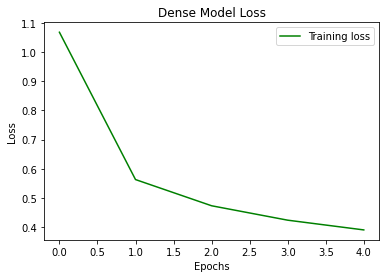

In [17]:
loss_train = history_dense.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.title('Dense Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_loss_dense.png")
plt.show()

Comments: 

* After 5 epochs, the pure dense model has test accuracy higher than 76% percent. 
* Although the model still has minor over-fitting, the accuracy is higher than we expected. Thus, we believe that using a dense network trained on flattened image is a good option for recognizing the mathematical expressions.

# Section II: Pre-Trained ResNet Model trained on Unflattened Images

In this section, we use the ResNet50 model, a convolutional neural network that is 50 layers deep for image classification, to predict the corresponding latex codes using unflattened images. 

Step 1: Reshape the array to unflatten and expand the image datapoints. 

In [10]:
train_image_ds = train_ds
test_image_ds = test_ds

In [11]:
for i in range(len(train_image_ds)):
    arr = train_image_ds['features'][i]
    train_image_ds['features'][i] = arr.reshape((28,28,1))
for i in range(len(test_image_ds)):
    arr = test_image_ds['features'][i]
    test_image_ds['features'][i] = arr.reshape((28,28,1))

In [12]:
train_image_values = train_image_ds['features'].values
test_image_values = test_image_ds['features'].values
train_image_tensor = tf.convert_to_tensor(train_image_values.tolist())
test_image_tensor = tf.convert_to_tensor(test_image_values.tolist())

Step 2: Build our ResNet model with modified input layer and an additional output layer whose dimension corresponds to the number of classes in our dataset using the original ResNet50 model. 

In [13]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

In [14]:
model = ResNet50()

In [15]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Notice that the input layer of ResNet50 has shape (224, 224, 3), which doesn' match our input shape. Thus, we modified the first layer with input shape (28, 28, 1)

In [34]:
model_config = model.get_config()

In [17]:
model_config['layers'][0]

{'class_name': 'InputLayer',
 'config': {'batch_input_shape': (None, 224, 224, 3),
  'dtype': 'float32',
  'sparse': False,
  'ragged': False,
  'name': 'input_1'},
 'name': 'input_1',
 'inbound_nodes': []}

In [18]:
model_config['layers'][1]

{'class_name': 'ZeroPadding2D',
 'config': {'name': 'conv1_pad',
  'trainable': True,
  'dtype': 'float32',
  'padding': ((3, 3), (3, 3)),
  'data_format': 'channels_last'},
 'name': 'conv1_pad',
 'inbound_nodes': [[['input_1', 0, 0, {}]]]}

In [19]:
model_config['layers'][0] = {
                      'name': 'our_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None, 28, 28, 1),
                          'dtype': 'float32',
                          'sparse': False,
                          'ragged': False,
                          'name': 'our_input'
                      },
                      'name': 'our_input',
                      'inbound_nodes': []
                  }
model_config['layers'][1]['inbound_nodes'] = [[['our_input', 0, 0, {}]]]
model_config['input_layers'] = [['our_input', 0, 0]]

In [20]:
new_model = model.__class__.from_config(model_config, custom_objects={})
new_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
our_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 1)    0           our_input[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 14, 14, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 14, 14, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Notice that to actually use the pre-trained model, we need to freeze most hidden layers in the ResNet50. 
After around 30 trials setting only the last 1, 3, 6, 9, 12, 16 layers trainable, we found that 9 gives us the highest accuracy. 

In [21]:
# Set the last 9 layers to be trainable gives us the highest accuracy after around 20 trials using 1, 3, 6, 9, 12, and 16.
for i in range(1,len(new_model.layers)-9):
    new_model.layers[i].trainable = False

Notice that the output layer of ResNet50 has dimension 1000, which doesn' match the number of output classes in our dataset. Thus, we add an additional dense layer with dimension 101. 

In [22]:
output_layer = tf.keras.layers.Dense(101, activation = 'softmax')
model_res = tf.keras.Sequential([new_model, output_layer])
model_res.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25630440  
_________________________________________________________________
dense (Dense)                (None, 101)               101101    
Total params: 25,731,541
Trainable params: 5,565,653
Non-trainable params: 20,165,888
_________________________________________________________________


Step 3: Train the model and Evaluate the Results

In [23]:
model_res.compile(optimizer = tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [27]:
history_resnet = model_res.fit(train_image_tensor, train_label_tensor, batch_size=32, epochs=15)

Epoch 1/15
9716/9716 [==============================] - 143s 14ms/step - loss: 3.6357 - acc: 0.0865
Epoch 2/15
9716/9716 [==============================] - 138s 14ms/step - loss: 2.9535 - acc: 0.1751
Epoch 3/15
9716/9716 [==============================] - 138s 14ms/step - loss: 2.3520 - acc: 0.3770
Epoch 4/15
9716/9716 [==============================] - 139s 14ms/step - loss: 1.7436 - acc: 0.5797
Epoch 5/15
9716/9716 [==============================] - 136s 14ms/step - loss: 1.3134 - acc: 0.6987
Epoch 6/15
9716/9716 [==============================] - 136s 14ms/step - loss: 1.0327 - acc: 0.7610
Epoch 7/15
9716/9716 [==============================] - 136s 14ms/step - loss: 0.8529 - acc: 0.7963
Epoch 8/15
9716/9716 [==============================] - 137s 14ms/step - loss: 0.7301 - acc: 0.8206
Epoch 9/15
9716/9716 [==============================] - 136s 14ms/step - loss: 0.6405 - acc: 0.8402
Epoch 10/15
9716/9716 [==============================] - 137s 14ms/step - loss: 0.5751 - acc: 0.8540

In [28]:
model_res.evaluate(test_image_tensor, test_label_tensor, batch_size=1)

5499/5499 [==============================] - 68s 12ms/step - loss: 2.2178 - acc: 0.5601


[2.2178432941436768, 0.5601018071174622]

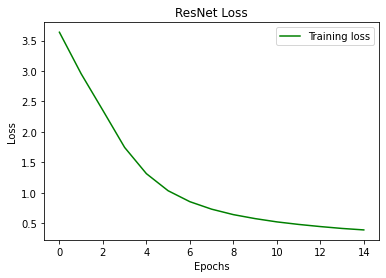

In [29]:
loss_train = history_resnet.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.title('ResNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_loss.png")
plt.show()

Comments: 
* Contradictory to our expectation, using the pre-trained ResNet50 model still has over-fitting problems even we have tried more than 30 rounds of trials and tests, with test accuracy lower than 60%. 
* In general, the ResNet50 takes far more time to train with lower test accuracy compared to the dense network.

# Conclusion: 

Through group discussion, we think training a dense network on unflattened images is a better choice for our Mathematical Expression Dataset extracted from the CROHME data based on the following reasons: 
* The Mathematical Expression Dataset we built has more than 0.3 million datapoints with balanced data. The dataset is large enough to train a model from scratch. 
* The images in our dataset are in graycale with low dimension (28x28). We believe the ResNet50 Model (224x224) will have better performance on image datasets with higher input dimension. 
* With OCR for mathematical expressions, we can transfer the mathematical expressions to latex codes, which is convenient for both students studying math and mathematicians since typing the latex codes by hand from paper drafts is boring and tiring. 

# Installation Code saved in this section: 

* ls("/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/")
* path_zip = '/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/'
* import zipfile
with zipfile.ZipFile('CROHME_full_v2.zip', 'r') as zip_ref:
    zip_ref.extractall(path_zip)
* !pip install scikit-image
* !pip install opencv-python
* Command Line Argument: -b [BOX_SIZE] -d [DATASET_VERSION] -c [CATEGORY] -t [THICKNESS]
* image1 = tf.keras.preprocessing.image.load_img('out.png')
* print(skimage.__version__)
cv2.__version__

# Citation: 
* (1) Dataset Explanation: https://www.cs.rit.edu/~dprl/old/CROHMELib_LgEval_Doc.html
* (2) Dataset Official Web Page: http://www.iapr-tc11.org/mediawiki/index.php?title=CROHME:_Competition_on_Recognition_of_Online_Handwritten_Mathematical_Expressions
* (3) OCR Academic Paper: https://arxiv.org/pdf/1906.01969.pdf
* (4) OCR using Tensorflow: https://medium.com/analytics-vidhya/optical-character-recognition-using-tensorflow-533061285dd3
* (5) Python Program for Extracting Data: https://github.com/ThomasLech/CROHME_extractor
* (6) ResNet Academic Paper: https://arxiv.org/abs/1512.03385
* (7) ResNet50 Tensorflow: https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691